In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
#using Clustering
#using GaussianMixtures

In [7]:
using GaussianMixtures

### Evaluation grids and sensors

In [8]:
# grid for full field evaluation
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)
zg = xg .+ im*yg';

# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 3
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 3
ϵsens = 0.0
lowerrow = range(-1.5,1.5,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Truth

In [105]:
Nv_cluster = 1 #3
Nv_per_cluster = 1 #5
δ_true = 0.1
xr = (-1.5,1.5)
yr = (0.1,1.0)
Γr = (0.0,2.0)
σx = 0.03
σΓ = 0.03
Nv_true = Nv_cluster*Nv_per_cluster 

zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
#zv = [-0.15+0.563im,1.17+0.48im]
#Γv = [1.77,1.77];

zv = [-0.5+0.5im]
Γv = [1.0]

config_data_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)

truez = zv


vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state_reordered(vort,config_data_true);

In [75]:
#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
=#

In [106]:
zv, Γv

(ComplexF64[-0.5 + 0.5im], [1.0])

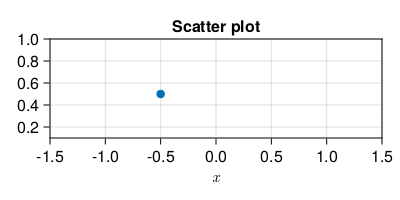

In [107]:
scatter(real.(zv),imag.(zv);
            figure = (; resolution = (400, 200)),
            axis = (; limits=(xr,yr),title = "Scatter plot", xlabel = L"x",aspect=DataAspect()))
    #,ratio=1,xlim=xr,ylim=yr,legend=false)

In [108]:
ptrue_field = analytical_pressure(zg,vort,config_data_true);

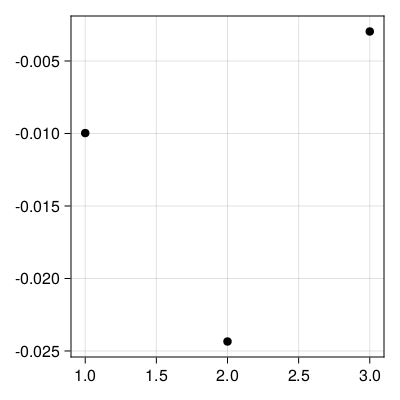

In [109]:
obs_true = PressureObservations(sens,config_data_true);
ystar = observations(x_true,obs_true);
f = plot(ystar; figure = (; resolution = (400, 400)))

## Single vortex estimation

In [110]:
Nv_one = 1
δ = 0.1

config_1vortex_data = VortexConfig(Nv_one, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #1e-3
ϵX = 5e-3 #0.05
ϵΓ = 1e-2 #0.05

# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,1.5)
Γr = (0.0,2.0)

obs = PressureObservations(sens,config_1vortex_data);

### MCMC approach

In [111]:
Σϵ = Diagonal(ϵmeas^2*ones(length(sens)));

In [112]:
function sort_state_by_strength(x,config::VortexConfig)
    zv, Γv = state_to_positions_and_strengths(x,config)
    #Γv = sum(Γv) < 0 ? -Γv : Γv
    #idx = sortperm(Γv)
    idx = 1:length(Γv)
    positions_and_strengths_to_state(zv[idx],Γv[idx],config)
end

sort_state_by_strength (generic function with 1 method)

In [113]:
Ntrial = 300000
propvarX = 0.01^2
propvarY = 0.01^2
propvarΓ = 0.01^2

0.0001

In [114]:
β = 10.0.^(range(0,-3,length=5))
#β = 2.0.^(range(0,-3,length=5))
nchain = length(β)
propvar = Diagonal(vcat(repeat([propvarX,propvarY],Nv_one),repeat([propvarΓ],Nv_one)))

#propvars = [propvar/β[i] for i = 1:nchain]
propvars = propvarX./β

xseed = generate_random_state(xr,yr,Γr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]
#xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> LowRankVortex.loglikelihood(x,ystar,Σϵ,obs),propvars;burnin=1,β=β,process_state=x->sort_state_by_strength(x,obs.config));

In [115]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.5089966666666667
 0.5235666666666666
 0.57778
 0.99473
 0.9969966666666666

In [116]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.21181496562312263
 0.18643955020294098
 0.00010711942476868899
 0.47233810751202404

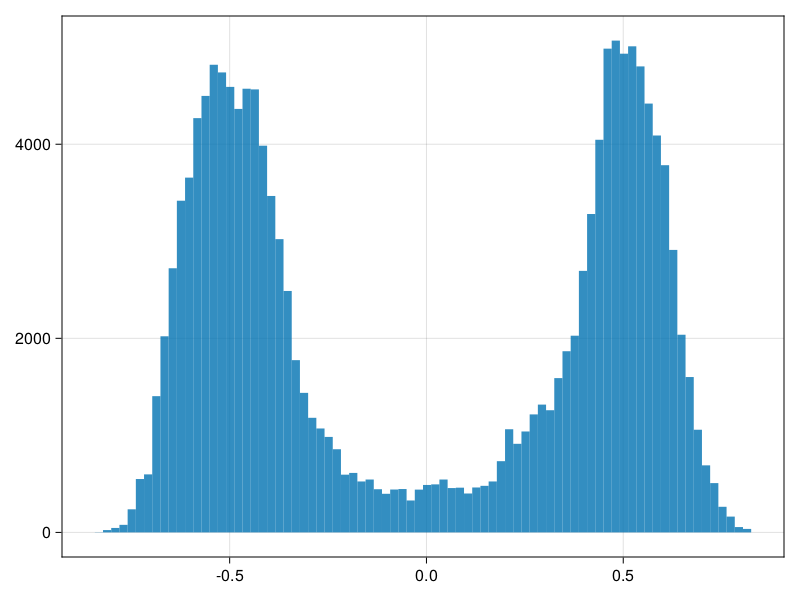

In [117]:
hist(x_data[1][2,Ntrial÷2:Ntrial],bins=80)
current_figure()

In [118]:
x_true

3-element Vector{Float64}:
 -0.5
  0.5
  1.0

In [119]:
x_fulldata_trans = x_data[1][:,Ntrial÷2:Ntrial]
x_fulldata = zero(transpose(x_fulldata_trans))
x_fulldata .= transpose(x_fulldata_trans);

In [1704]:
#=
x_data = Matrix[]
accept_data = Vector{Bool}[]
logp_data = Vector{Float64}[]
for n in 1:Nchains
    xseed = generate_random_state(xr,yr,Γr,obs.config)
    xlist, accept, logp = metropolis(xseed,Ntrial,x -> LowRankVortex.loglikelihood(x,ystar,Σϵ,obs);propvar=propvar)
    push!(x_data,deepcopy(xlist))
    push!(accept_data,copy(accept))
    push!(logp_data,copy(logp))
end

x_fulldata_trans = hcat(x_data...)
x_fulldata = zero(transpose(x_fulldata_trans))
x_fulldata .= transpose(x_fulldata_trans);
=#

In [1705]:
using Statistics

In [1399]:
function _autocorr(x,k,μ,σ2)
    lenx = length(x)
    x_adj = x .- μ
    corr = x_adj[1:lenx-k+1]'*x_adj[k:lenx]
    return corr/lenx/σ2
end

_autocorr (generic function with 1 method)

In [1400]:
sumρ = 0.0
lenx = size(x_data[1],2)
ρk, ρtest = 0.0, 1.0
k = 0
x = x_data[1][1,:]
μ, σ2 = mean(x), var(x)
while ρtest > 0.0
    k += 1
    oldρ = ρk
    ρk = _autocorr(x,k,μ,σ2)
    ρtest = oldρ + ρk
    sumρ += ρk
end
lenx/(1+2sumρ)

8.141015672389063

In [120]:
gm = GMM(2,x_fulldata,kind=:full,method=:kmeans,nIter=30);

K-means converged with 4 iterations (objv = 57.78354387871236)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 3 dimensions using 150001 data points
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79
┌ Info: K-means with 2000 data points using 4 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141


In [121]:
weights(gm)

2-element Vector{Float64}:
 0.5038411973426536
 0.49615880265734635

In [122]:
x_true

3-element Vector{Float64}:
 -0.5
  0.5
  1.0

In [123]:
transpose(means(gm)[weights(gm).>0.3,:])

3×2 transpose(::Matrix{Float64}) with eltype Float64:
 -0.501813  -0.502937
 -0.472982   0.460952
  0.992619   0.988309

In [124]:
covars(gm)[1]

3×3 Matrix{Float64}:
  0.00182436  -0.0053025   0.0028801
 -0.0053025    0.0187919  -0.0103268
  0.0028801   -0.0103268   0.0060772

In [125]:
xmean_array = states_to_vortex_states(transpose(means(gm)[weights(gm).>0.6,:]),config_1vortex_data);

In [130]:
function draw_ellipse(μ::Vector,Σ::Matrix)
    θ = range(0,2π,length=100)
    xc, yc = cos.(θ), sin.(θ)
    sqrtΣ = sqrt(Σ)
    xell = μ[1] .+ sqrtΣ[1,1]*xc .+ sqrtΣ[1,2]*yc
    yell = μ[2] .+ sqrtΣ[2,1]*xc .+ sqrtΣ[2,2]*yc
    return xell,yell
end

draw_ellipse (generic function with 1 method)

In [133]:
xm, ym = transpose(means(gm)[weights(gm).>0.3,:])
Σ = covars(gm)[weights(gm).>0.3,:]

2×1 Matrix{Matrix{Float64}}:
 [0.0018243621816177041 -0.00530250168099083 0.0028801040930749597; -0.00530250168099083 0.018791892412056792 -0.010326761400054273; 0.0028801040930749597 -0.010326761400054273 0.006077200609184096]
 [0.001954411843926083 0.006220030945593225 0.0031711223922157835; 0.006220030945593225 0.024641268743159844 0.0123297451985973; 0.0031711223922157835 0.0123297451985973 0.006741177516369374]

In [134]:
length(Σ)

2

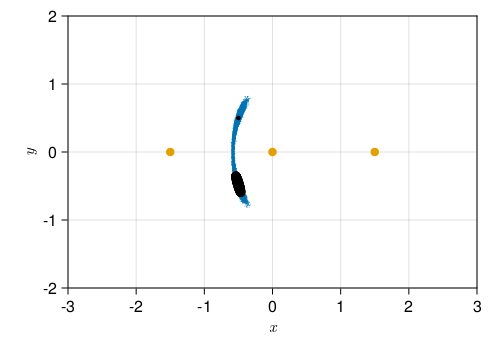

In [127]:
f = Figure(;resolution=(500,350))

ax = Axis(f[1,1];limits=(-3,3,-2,2),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")

for n in 1:1
    x_array = states_to_vortex_states(x_data[n][:,Ntrial÷2:4:Ntrial],obs.config);
    scatter!(ax,x_array[1,:],x_array[2,:],markersize=1)
end

xm, ym = transpose(means(gm)[weights(gm).>0.3,:])
Σ = covars(gm)[weights(gm).>0.3,:]
for i = 1:length(Σ)
    xell, yell = draw_ellipse([xm[]])
end

#scatter!(ax,xmean_array[1,:],xmean_array[2,:],marker=:circle,markersize=10,color=:transparent,strokewidth=1)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=5,color=:black,strokewidth=1)
plot!(ax,xell,yell)
scatter!(ax,real(sens),imag(sens))
#save("samples-2vortex-2truth-6sensor-case0.pdf",f)
f

In [1741]:
xbest = vec(transpose(means(gm)[weights(gm).>0.3,:]))

6-element reshape(transpose(::Matrix{Float64}), 6) with eltype Float64:
  0.9875251575414719
 -0.3156478710753839
  0.1925375444270943
  0.7120390142476614
  1.38724102364723
  2.2646864705698397

### Iterative EnKF approach

In [776]:
sol_collection = vortexinference(ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,obs; linear_flag=false,numsample=200,maxiter=250,errtol=0.025,inflate=true);

In [777]:
xlist = collect_estimated_states(sol_collection,obs.config)
x_array = states_to_vortex_states(xlist,obs.config);

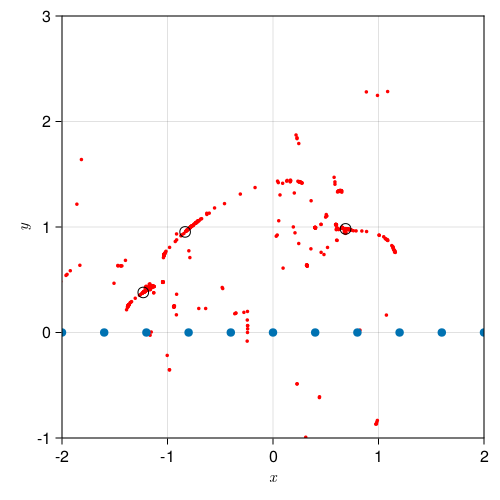

In [778]:
f = Figure(;resolution=(500,500))

ax = Axis(f[1,1];limits=(-2,2,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
scatter!(ax,x_array[1,1:end],x_array[2,1:end],markersize=5,color=:red)
#scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
scatter!(ax,real(sens),imag(sens))
current_figure()

#### Classify the trajectories

In [779]:
goodones, minyerr, sol_yerr = classify_by_data_mismatch(sol_collection,obs,kcluster=5);
sol_goodones = sol_collection[goodones]
xgoodlist = collect_estimated_states(sol_goodones,obs.config)
xgood_array = states_to_vortex_states(xgoodlist,obs.config);

bestones = classify_by_density(sol_goodones,obs);
sol_bestones = sol_goodones[bestones]
xtoplist = collect_estimated_states(sol_bestones,obs.config)
xtop_array = states_to_vortex_states(xtoplist,obs.config);

bestsol = sol_bestones[1]
xbest = mean(bestsol[end].X)
xbest_array = state_to_vortex_states(xbest,obs.config)

3×3 Matrix{Float64}:
 -1.37333   0.657278  -1.03283
  0.252821  0.993097   0.735348
  0.638255  1.6916     0.94418

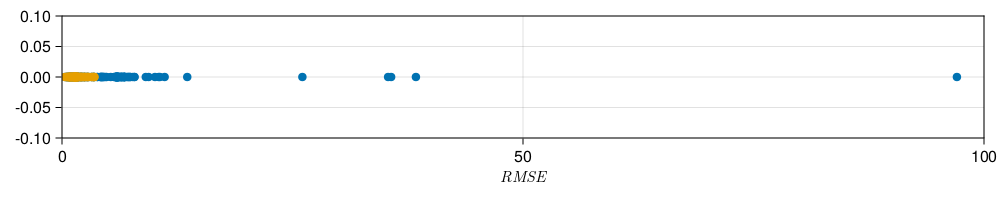

In [780]:
f = Figure(;resolution=(1000,200))
ax = Axis(f[1,1];limits=(0,100,-0.1,0.1),xlabel=L"RMSE")
scatter!(ax,sol_yerr,zero(sol_yerr))
scatter!(ax,sol_yerr[goodones],zero(sol_yerr[goodones]))
#save("errorclusters-2vortex-2truth-11sensor-cluster3.pdf",f)
f

In [781]:
minyerr

1.5598701804339357

#### Plotting the best estimates

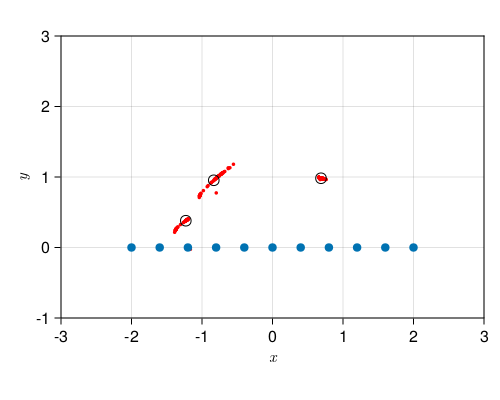

In [782]:
f = Figure(;resolution=(500,400))
ax = Axis(f[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
#scatter!(ax,xgood_array[1,:],xgood_array[2,:],markersize=5)
scatter!(ax,xtop_array[1,:],xtop_array[2,:],markersize=5,color=:red)
#scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
scatter!(ax,real(sens),imag(sens))
current_figure()

In [437]:
using GaussianMixtures

In [438]:
x_data = zero(transpose(xgood_array));
x_data .= transpose(xgood_array);
gm = GMM(5,x_data);
xbest_array = transpose(means(gm))

K-means converged with 5 iterations (objv = 0.00029228846294193644)


┌ Info: Initializing GMM, 5 Gaussians diag covariance 3 dimensions using 288 data points
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79
┌ Info: K-means with 288 data points using 5 iterations
│ 14.4 data points per parameter
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4, 5]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4, 5]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4, 5]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4, 5]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had 

3×5 transpose(::Matrix{Float64}) with eltype Float64:
 -0.227555  1.29613   1.29656   -0.227164  1.29636
  0.555863  0.609352  0.608058   0.557068  0.608772
  0.932785  1.55908   1.55633    0.93412   1.55769

In [439]:
covars(gm)

5×3 Matrix{Float64}:
 3.86602e-7  3.57526e-7  7.82034e-7
 2.69248e-7  1.68698e-7  6.37396e-7
 1.07421e-7  1.56318e-7  3.78193e-7
 3.87083e-7  3.47163e-7  4.37579e-7
 1.31787e-7  1.44097e-7  1.80121e-7

In [440]:
weights(gm)

5-element Vector{Float64}:
 0.22617501342188862
 0.1642362564559861
 0.19538919705849364
 0.2738249865781115
 0.1403745464855203

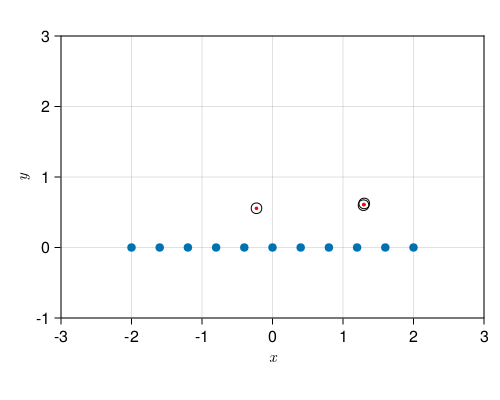

In [441]:
f = Figure(;resolution=(500,400))
ax = Axis(f[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
#scatter!(ax,xgood_array[1,:],xgood_array[2,:],markersize=5)
scatter!(ax,xbest_array[1,1:3],xbest_array[2,1:3],markersize=5,color=:red)
#scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
scatter!(ax,real(sens),imag(sens))
current_figure()

In [22]:
# using x error
#=
minxerr, bestone = findmin(collection_xerr)
xthresh = minxerr + 50.0
bestsol = sol_collection[bestone];
goodones = findall(x -> x <= xthresh,collection_xerr)
badones = findall(x -> x > xthresh,collection_xerr);

xgood = collect_estimated_states(sol_collection[goodones],obs.config);
xbad = collect_estimated_states(sol_collection[badones],obs.config);
=#

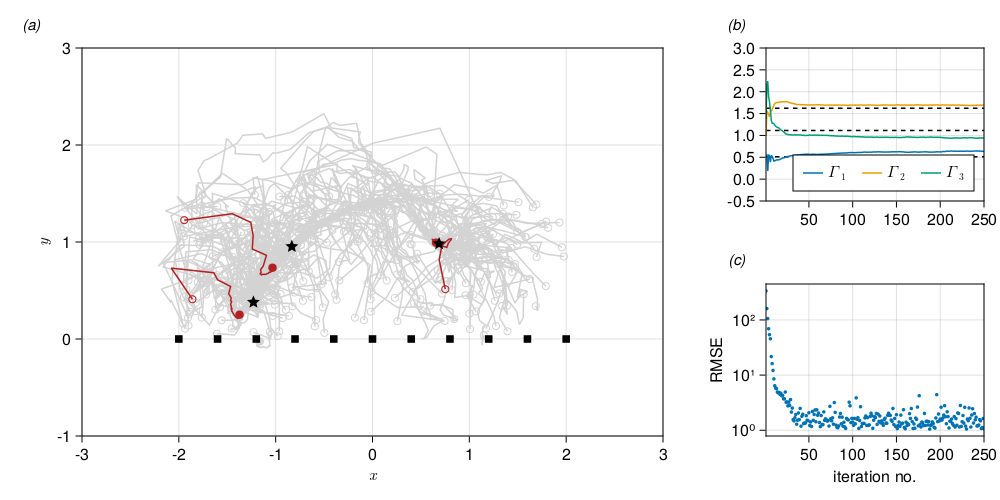

In [783]:
fulltraj = true
plotbadones = false

sampsol = bestsol #sol_collection[goodones[2]]

ftraj = Figure(;resolution=(1000,500))
ga = ftraj[1,1] = GridLayout()
gb = ftraj[1,2] = GridLayout()

axtraj = Axis(ga[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
with_theme(LowRankVortex.trajectory_theme()) do    
    
    if fulltraj
        for this_solhist in sol_bestones
            trajectory!(axtraj,this_solhist,obs,color=:lightgray)
        end
        if plotbadones
            for this_solhist in sol_collection[badones]
                trajectory!(axtraj,this_solhist,obs,color=LowRankVortex.color_palette[3])
            end
        end
        trajectory!(axtraj,bestsol,obs,color=LowRankVortex.color_palette[1])
    else
        xpost = vec(xgood[1,:])
        ypost = vec(xgood[2,:])
        Γpost = vec(xgood[3,:])
        scatter!(axtraj,xpost,ypost,markersize=5,color=LowRankVortex.color_palette[1])
        xbestpost = xbest_array[1,1:obs.config.Nv]
        ybestpost = xbest_array[2,1:obs.config.Nv]
        Γbestpost = xbest_array[3,1:obs.config.Nv]
        scatter!(axtraj,xbestpost,ybestpost,markersize=20,color=LowRankVortex.color_palette[2])
        xcenter = goodstate[1,:]
        ycenter = goodstate[2,:]
        Γcenter = goodstate[3,:]
        #scatter!(axtraj,xcenter,ycenter,markersize=20,color=LowRankVortex.color_palette[4])
    end
    scatter!(axtraj,real(sens),imag(sens),marker=:rect,color=:black)
    scatter!(axtraj,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
end
#save("soltraj-1vortex-3sensor.pdf",ftraj)   

# circulation plot
gb1 = gb[1,1] = GridLayout()
gb2 = gb[2,1] = GridLayout()
axa = Axis(gb1[1,1];limits=(1,length(sampsol),-0.5,3.0))
ztrue, Γtrue = state_to_positions_and_strengths(x_true,config_data_true)
for j in 1:config_data_true.Nv
    #lines!(axa,real(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    #lines!(axa,imag(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    lines!(axa,Γtrue[j]*ones(length(sampsol)),linestyle=:dash,color=:black)
end
for j in 1:obs.config.Nv
    #lines!(axa,map(x -> mean(x.Xf)[2j-1],sampsol),markersize=2,label=L"x")
    #lines!(axa,map(x -> mean(x.Xf)[2j],sampsol),markersize=2,label=L"y")
    lines!(axa,map(x -> mean(x.Xf)[2obs.config.Nv+j],sampsol),markersize=2,label=L"\Gamma_{%$j}")
end
axislegend(axa,orientation=:horizontal,position=:rb)

yerrhist = map(x -> x.yerr,sampsol)
axb = Axis(gb2[1,1];yscale=log10,xlabel="iteration no.",ylabel="RMSE")
linkxaxes!(axb,axa)
pl = scatter!(axb,yerrhist,markersize=5)
xlims!(axb,(1,length(yerrhist)))
#save("convergence-1vortex-3sensor.pdf",f)

colsize!(ftraj.layout, 2, Auto(0.35))

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb1, gb2])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 20, 15, 0),
        halign = :right)
end

#save("trajectories-1vortex-1truth-3sensor-case0.pdf",ftraj)
ftraj

In [594]:
#=
dx = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[1],solhist);
dy = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[2],solhist);
dΓ = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[3],solhist);
#scatter(cumsum(dx),cumsum(dy))
=#

#### Plotting the basic data

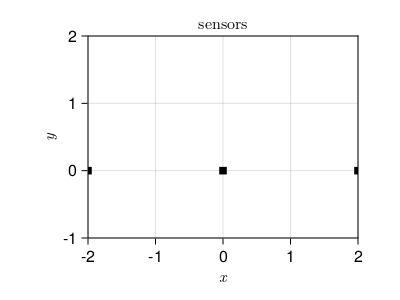

In [30]:
f = Figure(;resolution=(400,300))
ga = f[1, 1]

axleft = Axis(ga;xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
scatter!(axleft,real.(sens),imag.(sens),marker=:rect,color=:black)

save("basicdata-3sensor.pdf",f)

f

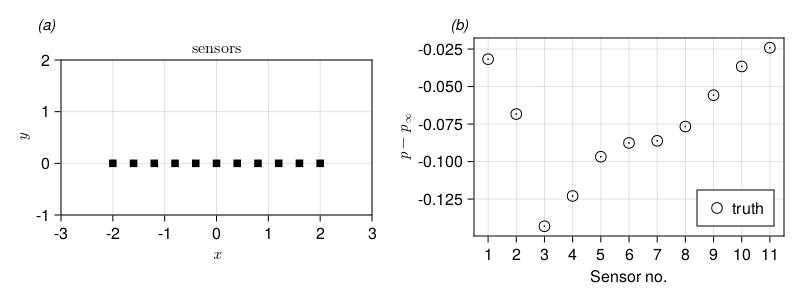

In [784]:
f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
scatter!(axleft,real.(sens),imag.(sens),marker=:rect,color=:black)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
scatter!(axcenter,ystar,markersize=15,color=:transparent,strokewidth=1,label="truth")
errorbars!(axcenter,1:length(ystar),ystar,ϵmeas*ones(length(ystar)))
#scatter!(axcenter,y_post,markersize=10,color=:black,label="estimate")
axislegend(axcenter,position=:rb)

for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

In [1742]:
vort_post = state_to_lagrange_reordered(xbest,obs.config;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(xbest,obs)
p_post_field = analytical_pressure(zg,vort_post,obs.config);

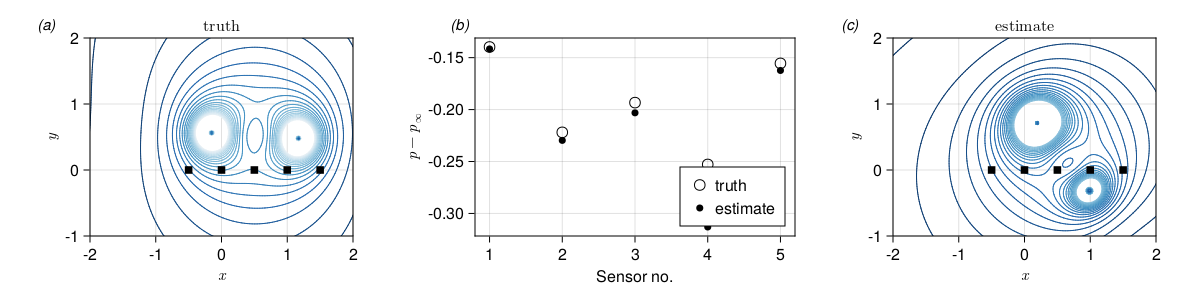

In [1743]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
contour!(axleft,xg,yg,ptrue_field,levels=l,colormap=:RdBu)
scatter!(axleft,real.(sens),imag.(sens),marker=:rect,color=:black)
contour!(axright,xg,yg,p_post_field,levels=l,colormap=:RdBu)
scatter!(axright,real.(sens),imag.(sens),marker=:rect,color=:black)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
scatter!(axcenter,ystar,markersize=15,color=:transparent,strokewidth=1,label="truth")
scatter!(axcenter,y_post,markersize=10,color=:black,label="estimate")
axislegend(axcenter,position=:rb)

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-1vortex-1truth-3sensor-case0.pdf",f)

f

#### Plotting the cost function

In [43]:
# start with the final mean state
xmin, xmax = -2, 2
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)

jdex = length(bestsol)
sol = bestsol[jdex]
xbase = mean(sol.X)

jdex = 5
sol0 = bestsol[jdex]
xbase0 = mean(sol0.X)

Nv = obs.config.Nv

costmap = zeros(length(xg),length(yg))
costmap_p = zeros(length(xg),length(yg))
costmap_m = zeros(length(xg),length(yg))

xij = copy(xbase)
xij0 = copy(xbase0)

v_explore = 1

for (j,yj) in enumerate(yg)
    xij[2v_explore] = yj
    xij0[2v_explore] = yj
    for (i,xi) in enumerate(xg)
        xij[2v_explore-1] = xi
        hx = observations(xij,obs)
        costmap[i,j] = norm(ystar-hx,sol.Σy)
        xij0[2v_explore-1] = xi
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore] + 0.3
        hx_p = observations(xij0,obs)
        costmap_p[i,j] = norm(ystar-hx_p,sol.Σy)
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore] - 0.3
        hx_m = observations(xij0,obs)
        costmap_m[i,j] = norm(ystar-hx_m,sol.Σy)
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore]
    end
end

In [45]:
[minimum([minimum(costmap_p),minimum(costmap)]),maximum([maximum(costmap_p),maximum(costmap)])]

2-element Vector{Float64}:
   0.0856413720577743
 325.44731819679356

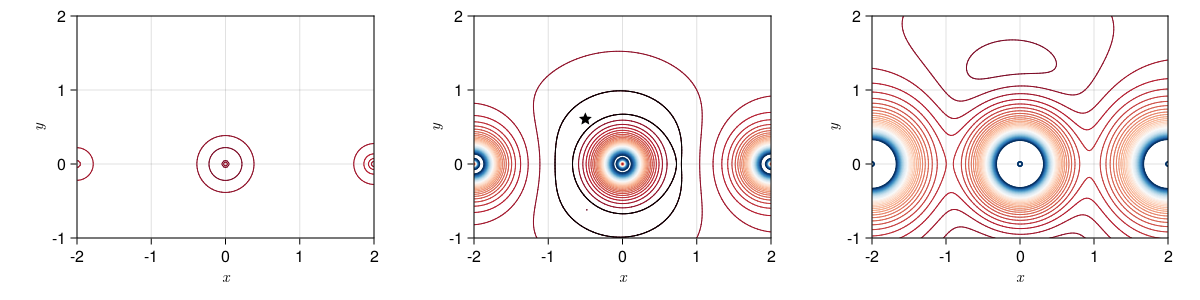

In [46]:
minc = minimum([minimum(costmap_p),minimum(costmap)])
dc = 100 # maximum([maximum(costmap_p),maximum(costmap)])
f = Figure(;resolution=(1200,300))
ga = f[1,1] = GridLayout()
gb = f[1,2] = GridLayout()
gc = f[1,3] = GridLayout()
axa = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
axb = Axis(gb[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
axc = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
linkaxes!(axb,axa)
linkaxes!(axc,axa)
pa = contour!(axa,xg,yg,costmap_m,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
contour!(pa,xg,yg,costmap_m,levels=[minc],color=:black)
pb = contour!(axb,xg,yg,costmap,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
l = pb.attributes[:levels].val[2]
contour!(pb,xg,yg,costmap,levels=[l],color=:black)
scatter!(pb,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
pc = contour!(axc,xg,yg,costmap_p,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
#save("errorfunc-1vortex-1truth-3sensor-L3.pdf",f)
f

In [1008]:
zmean_1vortex, Γmean_1vortex = state_to_positions_and_strengths(mean(bestsol[end].X),config_1vortex_data)
transpose([vortexmoment(0,zv,Γv) vortexmoment(0,zmean_1vortex,Γmean_1vortex) vortexmoment(1,zv,Γv)/vortexmoment(0,zv,Γv) vortexmoment(1,zmean_1vortex,Γmean_1vortex)/vortexmoment(0,zmean_1vortex,Γmean_1vortex)])

4×1 transpose(::Matrix{ComplexF64}) with eltype ComplexF64:
  2.3265442402896843 + 0.0im
  2.3205731283403104 + 0.0im
 0.22311955671696976 + 0.3901459595209079im
 0.20053817740994953 + 0.3732964458631035im

In [26]:
solhist[end].V

3×3 Matrix{Float64}:
 -0.00755809   0.999962    -0.00429278
 -0.985451    -0.00671935   0.169826
  0.169791     0.00551389   0.985465

In [27]:
solhist[end].Λx

3-element Vector{Float64}:
 594.1038936212367
 116.28626229574081
   1.647571849018611

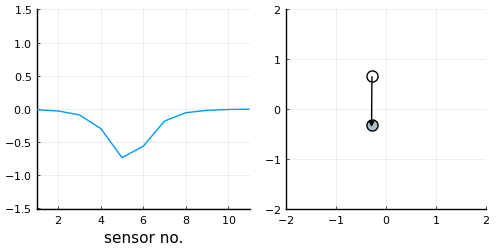

In [28]:
showmode(50,1,solhist,config_1vortex_data,size=(500,250),markersize=8,xlim=(-2.0,2.0),ylim=(-2.0,2.0))

In [29]:
solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)

3×3 Matrix{Float64}:
  0.0409346    2.0098e-5    0.00184311
 -5.94799e-5   0.0924307    0.000353381
  0.000312875  0.000422218  0.595419

### Multiple vortices

In [593]:
Nv = 2
δ = 0.2

config_data = VortexConfig(Nv, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #5e-4 #1e-3
ϵX = 5e-3 #5e-3 #0.05
ϵΓ = 5e-3 #5e-3 #0.05

# ranges to confine the prior to
xr = (-1.5,1.5)
yr = (0.0,1.5)
Γr = (0.0,2.0)

obs = PressureObservations(sens,config_data);

In [594]:
sol_collection = vortexinference(ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,obs,linear_flag=false,maxiter=250,errtol=0.025,numsample=20,inflate=true);

In [595]:
collection_yerr = map(x -> x[end].yerr,sol_collection)

20-element Vector{Float64}:
  80.50728779749859
  16.21516379261435
  18.55933440793088
  24.173439853224945
 109.90993875549869
 223.45358902249373
   7.35517865227772
  29.03021019760188
  18.585267106233214
  13.577163147438895
 170.09191967145583
   7.368878180280386
  15.029559944709705
  15.752448348778731
   0.02301091929209901
  14.650804871986628
  19.117430759372205
  19.143889816631464
  86.42525764294972
  94.59460655305911

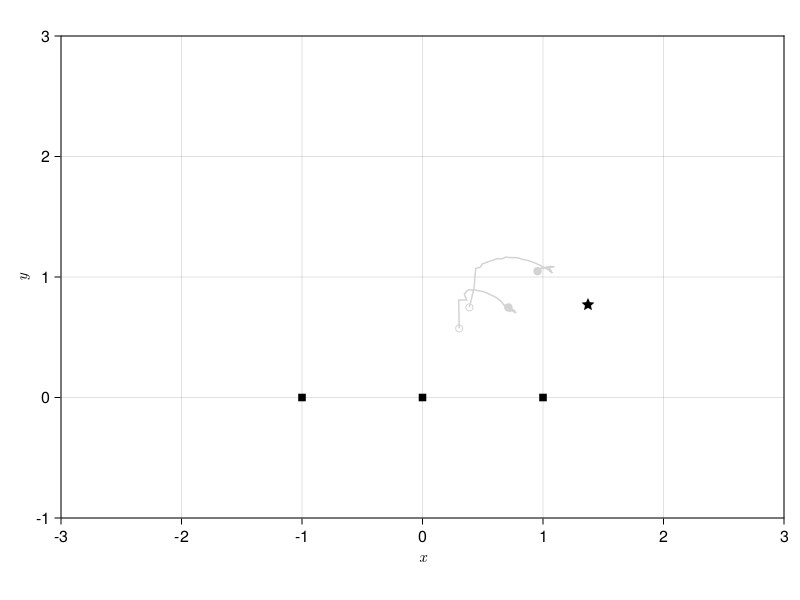

In [596]:
f = Figure()
axtraj = Axis(f[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
with_theme(LowRankVortex.trajectory_theme()) do    
    #for this_solhist in sol_collection[goodones]
        trajectory!(axtraj,sol_collection[2],obs,color=:lightgray)
    #end
    #trajectory!(axtraj,bestsol,obs,color=LowRankVortex.color_palette[1])
    scatter!(axtraj,real(sens),imag(sens),marker=:rect,color=:black)
    scatter!(axtraj,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
end
f

In [123]:
perr = []
for solhist in sol_collection
    jdex = length(solhist)
    vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
    p_post_field = analytical_pressure(zg,vort_post,config_data)
    push!(perr,norm(ptrue_field-p_post_field)/norm(ptrue_field))
end

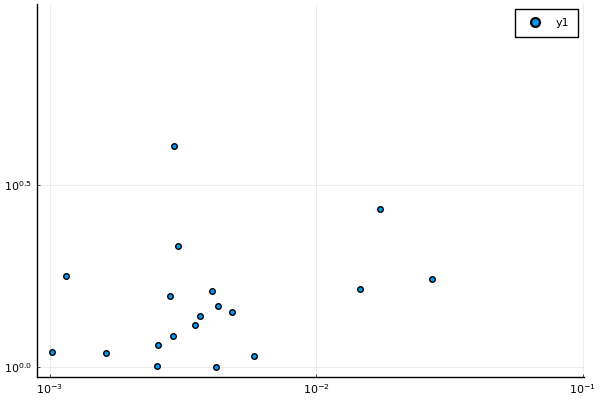

In [33]:
scatter(collection_err*ϵmeas,perr,scale=:log10)

In [130]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

In [131]:
minerr

2.679486384986046

In [36]:
perr[sampnum]

1.1039726302191541

In [677]:
minperr, sampnum = findmin(perr)
solhist = sol_collection[sampnum];
minerr = collection_err[sampnum]

8.555369230739387

In [918]:
minerr*ϵmeas

0.000823171294532819

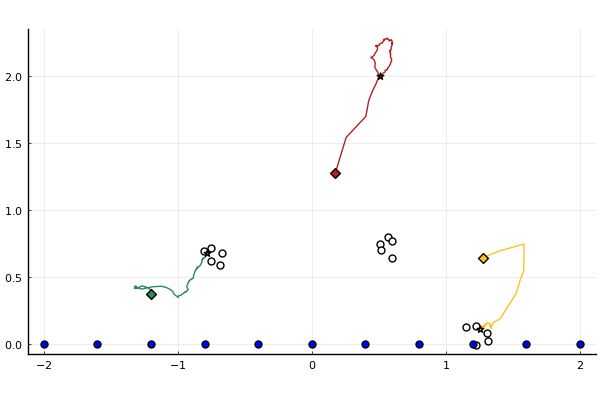

In [132]:
pl = filtertrajectory(solhist,obs,vort,markersize=5,legend=:false)
#savefig("3cluster-traj-3vortex-11linesensors.pdf")
#display(pl)

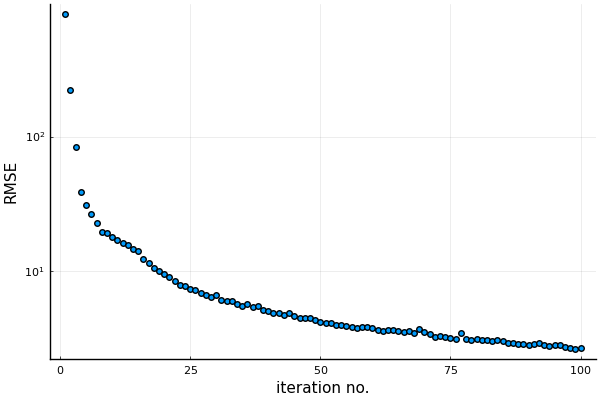

In [133]:
yerrhist = map(x -> x.yerr,solhist)
scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lW9ll/src/animation.jl:137


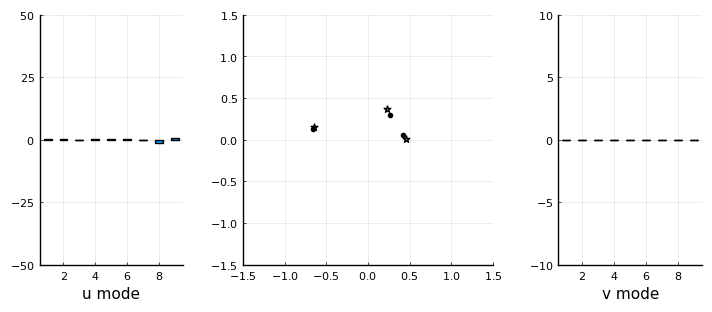

Plots.AnimatedGif("/Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif")
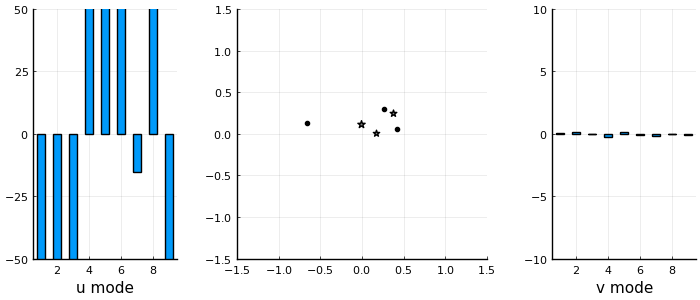

In [778]:
@gif for j in 1:length(solhist)
    filterstepplot(j,solhist,x_true,xlim=(-1.5,1.5),ylim=(-1.5,1.5),size=(700,300),arrows_on=false,ubarscale=0.1,vbarscale=0.1)
end every 2

The Kalman gain isn't diagonally dominant. Mixes U and V modes together. In particular, higher U modes affect most V modes.

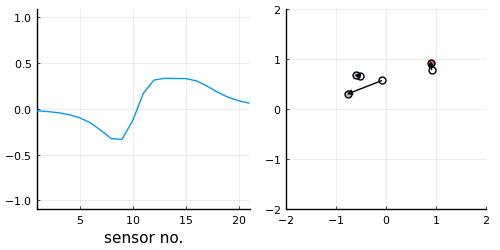

In [344]:
showmode(100,2,solhist,config_data,size=(500,250),xlim=(-2,2),ylim=(-2,2))

In [345]:
(solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)).diag

9-element Vector{Float64}:
 0.26691182937350977
 0.4612485658255621
 0.4992840956956534
 0.48894157312115305
 0.40584969917653485
 0.35102396492451765
 0.30115145006403
 0.1261610131156297
 0.057328954009867435

In [134]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(mean(solhist[jdex].X),obs)
p_post_field = analytical_pressure(zg,vort_post,config_data)
vort_post

3-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(0.5062726276565196 + 1.9914461182948457im, -0.3709634624156531, 0.2)
 Vortex.Blob(-0.7805035252254179 + 0.6781614048010681im, 0.5580201950784153, 0.2)
 Vortex.Blob(1.2538800326167074 + 0.1173340577552869im, 0.6215766738713608, 0.2)

In [41]:
vortexmoment(1,zv_post,Γ_post)

-1.5334675960989748 + 2.486371056137739im

In [42]:
vortexmoment(1,zv,Γv)

-1.5888933471547861 + 2.5957058796524626im

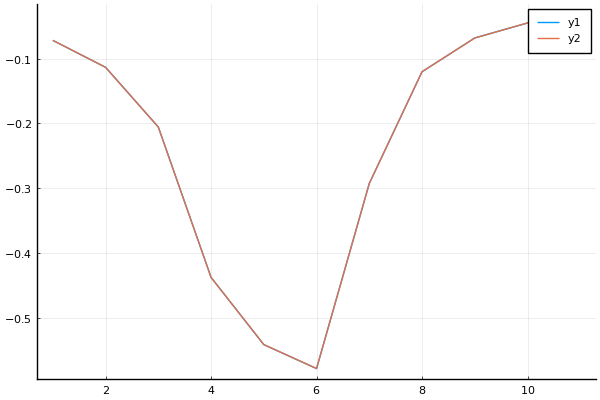

In [43]:
plot(y_post)
plot!(ystar)

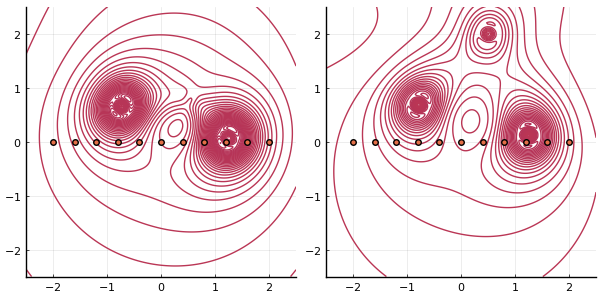

In [136]:
#l = range(-1,1,length=31)
#cl = (-1,1)
pl1 = plot(xg,yg,ptrue_field',ratio=1,clim=cl,levels=31,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl1,real.(sens),imag.(sens))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = plot(xg,yg,p_post_field',ratio=1,clim=cl,levels=31,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl2,real.(sens),imag.(sens))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-3vortex-11linesensors.pdf")
#display(p1)

In [45]:
norm(ptrue_field-p_post_field)/norm(ptrue_field)

1.1039726302191541

### Explore the cost function topology
Here, we will map out the cost function's dependence on two components of the state, while
keeping the others fixed.

In [1591]:
# start with the final mean state
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)

jdex = 500 #length(solhist)
xbase = mean(solhist[jdex].X)

costmap = zeros(length(xg),length(yg))
costmap_p = zeros(length(xg),length(yg))
costmap_m = zeros(length(xg),length(yg))

xij = copy(xbase)

v_explore = 3

for (j,yj) in enumerate(yg)
    xij[2v_explore] = yj
    for (i,xi) in enumerate(xg)
        xij[2v_explore-1] = xi
        hx = observations(xij,pressure,sens,config_data)
        costmap[i,j] = norm(ystar-hx,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] + 0.05
        hx_p = observations(xij,pressure,sens,config_data)
        costmap_p[i,j] = norm(ystar-hx_p,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] - 0.05
        hx_m = observations(xij,pressure,sens,config_data)
        costmap_m[i,j] = norm(ystar-hx_m,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore]
    end
end

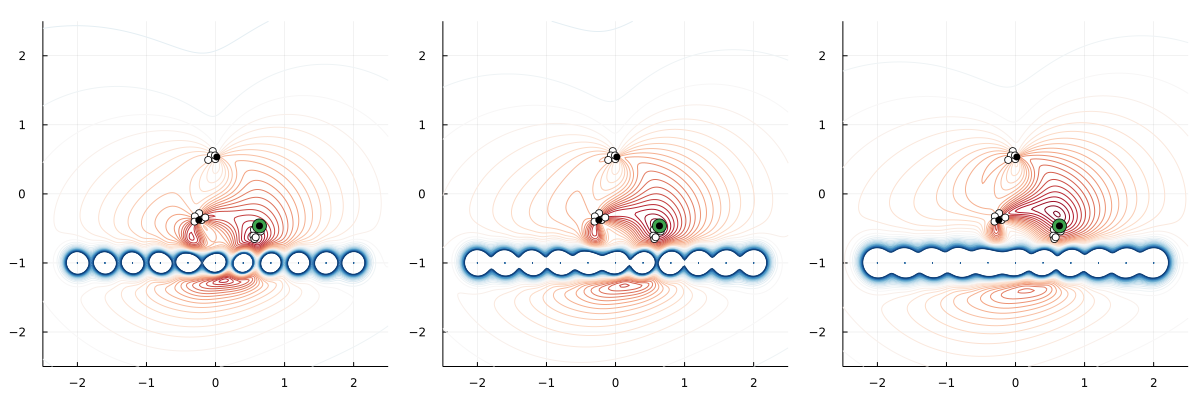

In [1592]:
truex = x_true[1:2:2Nv_true]
truey = x_true[2:2:2Nv_true]
currentx = xbase[1:2:2Nv]
currenty = xbase[2:2:2Nv]
minc = 0.3 #minimum([minimum(costmap_p),minimum(costmap),minimum(costmap_m)])
p1 = plot(xg,yg,costmap',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1,truex,truey,markercolor=:white,legend=false)
scatter!(p1,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_p = plot(xg,yg,costmap_p',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_p,truex,truey,markercolor=:white,legend=false)
scatter!(p1_p,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_p,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_m = plot(xg,yg,costmap_m',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_m,truex,truey,markercolor=:white,legend=false)
scatter!(p1_m,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_m,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

plot(p1_m,p1,p1_p,layout=(1,3),size=(1200,400))